# Raw data to clean data

In [3]:
# Python built-in packages
from dateutil import rrule
import datetime
from pathlib import Path
import sys
# Core
import pandas as pd
# Data visualization
import matplotlib.pyplot as plt
# Make project packages available
PROJECT_PATH = Path.cwd().parents[0]
if str(PROJECT_PATH) not in sys.path:
    sys.path = sys.path[:1] + [str(PROJECT_PATH)] + sys.path[1:]
from sqm import sqm_reader

In [4]:
import importlib
importlib.reload(sqm_reader)

<module 'sqm.sqm_reader' from '/home/rafael/git/projects/sqm/sqm/sqm_reader.py'>

In [5]:
puente_path = PROJECT_PATH/'data'/'puente_nacional_2020'
puente = sqm_reader.SQMReader(project_path=puente_path)

In [7]:
puente.dir_name

'puente_nacional_2020'

In [16]:
def remove_hours_between(df, start_hour, end_hour):
    before = df['dt_local'].dt.time <= start_hour
    after = df['dt_local'].dt.time >= end_hour
    
    return df[before | after].copy()


def assign_night(dt, **kwargs):
    time = dt.time()
    date = dt.date()
    if time < datetime.time(**kwargs):
        return date - datetime.timedelta(days=1)
    return date

In [17]:
df = puente.clean_data
df = remove_hours_between(df, datetime.time(hour=7), datetime.time(hour=17))
df['night'] = df['dt_local'].apply(assign_night, hour=7)

In [34]:
recorded_nights = df['night'].unique()
first_night = min(recorded_nights)
last_night = max(recorded_nights)
n_nights = (last_night - first_night).days
missing_nights = list()

print(f'First night {first_night}')
print(f'Last night {last_night}', '\n')
for i in range(1, n_nights+1):
    tmp_date = first_night + datetime.timedelta(days=i)
    if tmp_date not in recorded_nights:
        missing_nights.append(tmp_date)
print('Missing nights')
print(missing_nights)

First night 2020-02-29
Last night 2020-11-15 

Missing nights
[datetime.date(2020, 3, 20), datetime.date(2020, 3, 21), datetime.date(2020, 3, 22), datetime.date(2020, 3, 23), datetime.date(2020, 3, 24), datetime.date(2020, 3, 25), datetime.date(2020, 3, 26), datetime.date(2020, 3, 27), datetime.date(2020, 3, 28), datetime.date(2020, 6, 20), datetime.date(2020, 6, 21)]


In [37]:
month_first_days = list(
    rrule.rrule(
        rrule.MONTHLY,
        dtstart=first_night.replace(day=1),
        until=last_night.replace(day=1)
    )
)

month_codes = [f"{dt.year}-{dt.month}" for dt in month_first_days]
month_codes

['2020-2',
 '2020-3',
 '2020-4',
 '2020-5',
 '2020-6',
 '2020-7',
 '2020-8',
 '2020-9',
 '2020-10',
 '2020-11']

In [59]:
class Night:
    def __init__(self, data):
        self.night = data['night'].unique()[0]
        data = data.sort_values(by='dt_local')
        self.msas = data['msas'].values
        self.times = self.get_times(data)
        
    def get_times(self, data):
        times = data['dt_local'].dt.time.values
        return times

TypeError: float() argument must be a string or a number, not 'datetime.time'

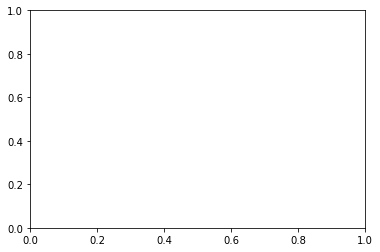

In [70]:
for night in df['night'].unique()[2:3]:
    tmp_df = df[df['night'] == night]
    nn = Night(tmp_df)
#     print(nn.times)
#     print(nn.msas)
    plt.plot(nn.times, nn.msas)

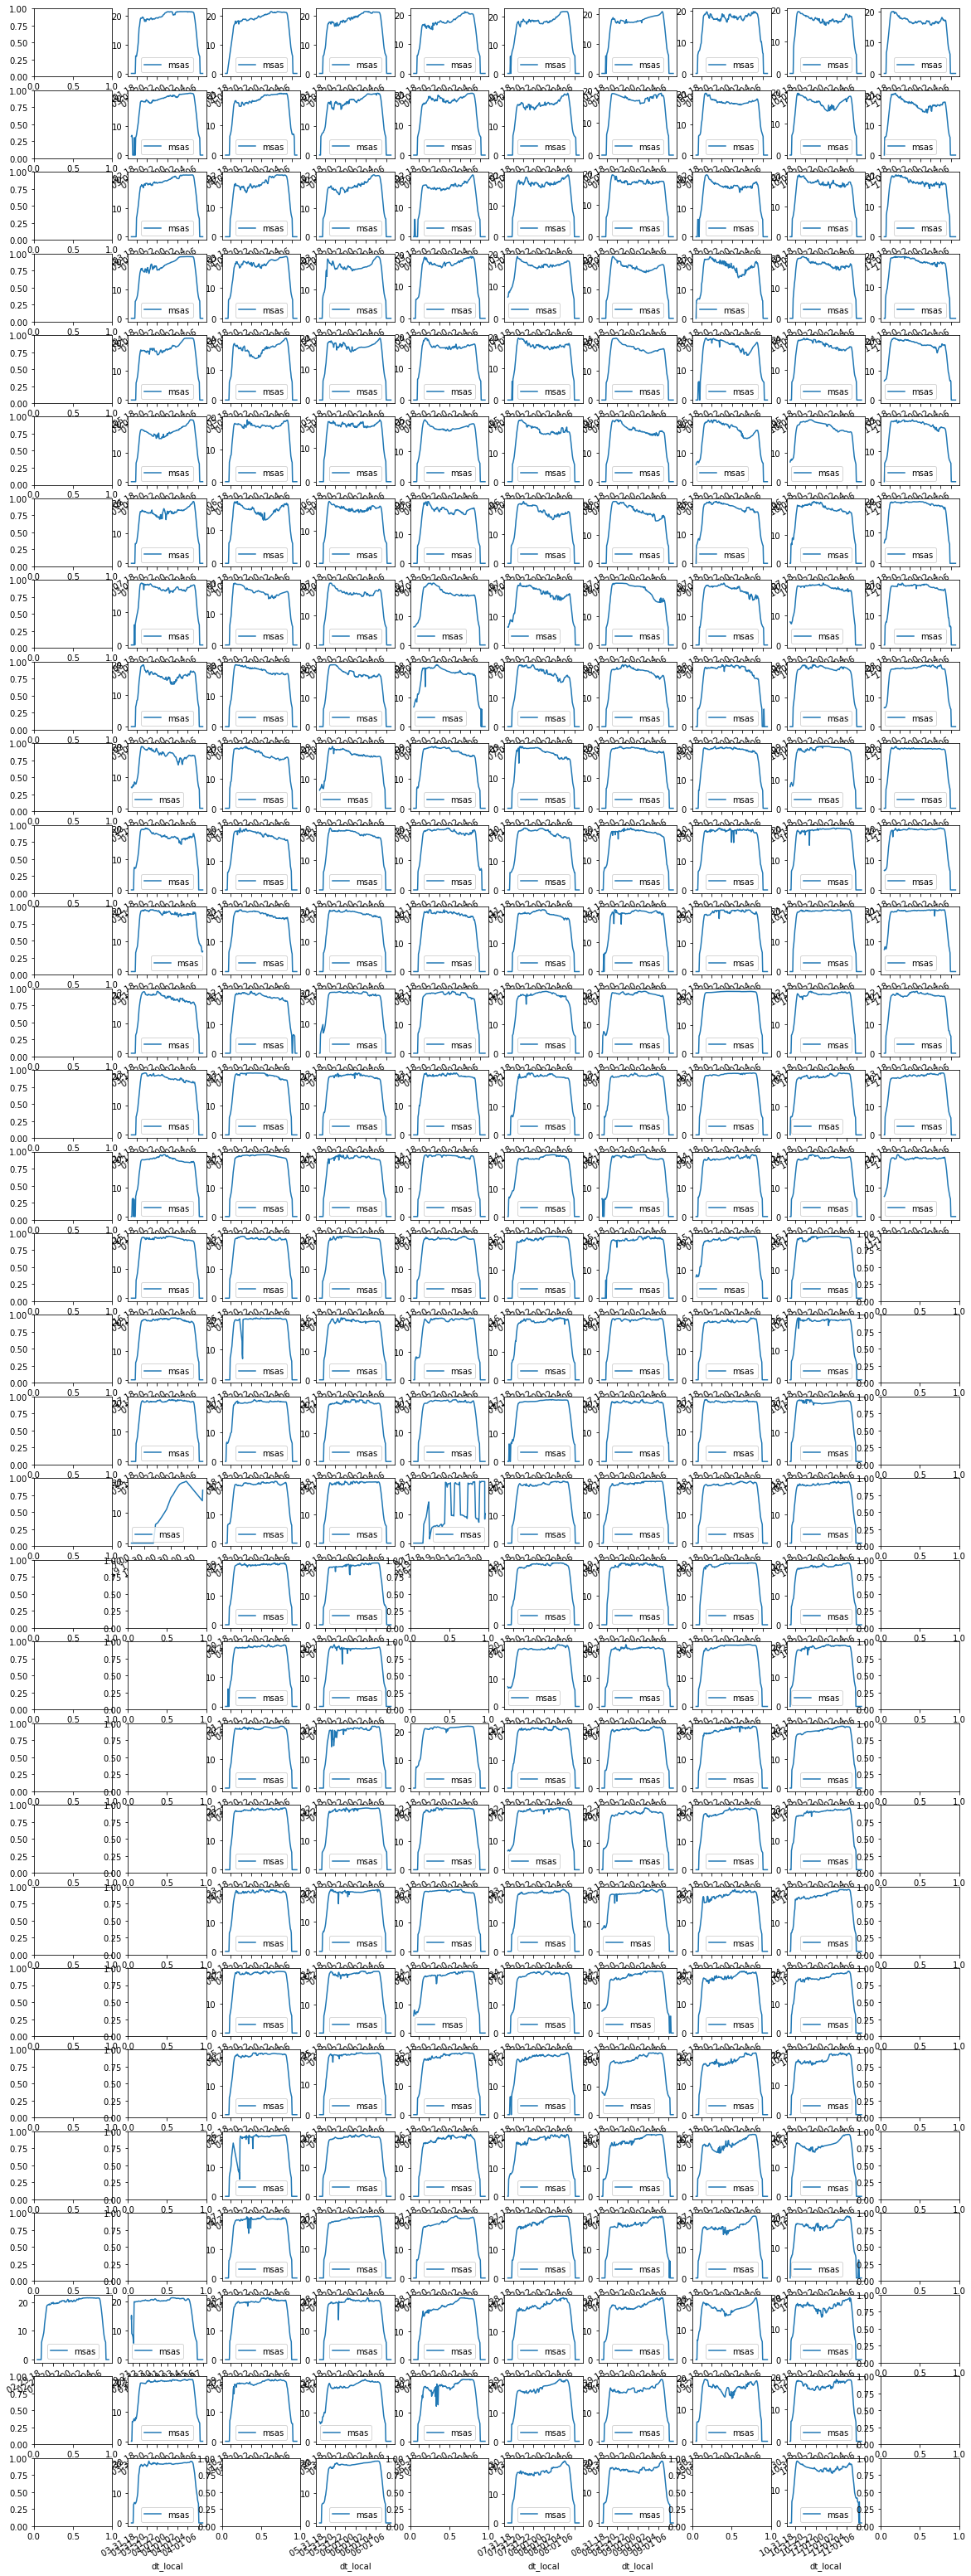

In [204]:
fig, axes = plt.subplots(31, len(dates), figsize=(len(dates)*2, 31*2))
for night in df['night'].unique():
    month = f"{night.year}-{night.month}"
    col = dates.index(month)
    row = night.day -1 
    df_night = df[df['night'] == night]
    df_night.plot(x='dt_local', y='msas', ax=axes[row, col])
fig.savefig('super.png')

In [18]:
months(last_night, first_night)

NameError: name 'months' is not defined

In [171]:
list(rrule.rrule(rrule.MONTHLY, dtstart=first_night, until=last_night))

[datetime.datetime(2020, 2, 29, 0, 0),
 datetime.datetime(2020, 3, 29, 0, 0),
 datetime.datetime(2020, 4, 29, 0, 0),
 datetime.datetime(2020, 5, 29, 0, 0),
 datetime.datetime(2020, 6, 29, 0, 0),
 datetime.datetime(2020, 7, 29, 0, 0),
 datetime.datetime(2020, 8, 29, 0, 0),
 datetime.datetime(2020, 9, 29, 0, 0),
 datetime.datetime(2020, 10, 29, 0, 0)]

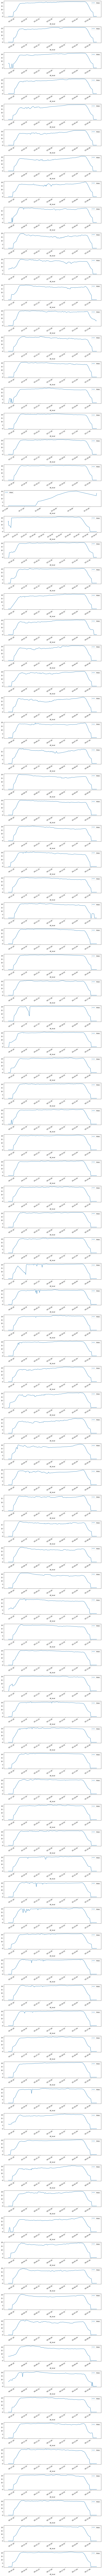

In [160]:
n = 100
fig, axes = plt.subplots(n,1, figsize=(10,n*2.5), tight_layout=True)
for i, night in enumerate(df['night'].unique()[:n]):
    df_night = df[df['night'] == night]
    df_night.plot(x='dt_local', y='msas', ax=axes[i])